This is more or less a copy of `Behavior_and_MVPA_Classification`, only without the behavioral analyses, and with the classifier result switched to one trained only on correct trials

# Preliminary stuff

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import networkx as nx
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_1samp, pearsonr, kendalltau
import matplotlib
import statsmodels.formula.api as smf
from matplotlib.patches import Rectangle
import matplotlib.transforms as transforms
from nilearn import surface, plotting
from graphs import (
    modular,
    ring_lattice,
    graph_df,
    subjects,
    subjects_lattice,
    subjects_modular
)
from roi_loader import Loader
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
# %config InlineBackend.figure_format = 'retina'
# matplotlib.rcParams.update({'font.sans-serif': "Helvetica"})
# matplotlib.rcParams.update({'font.serif': "Times"})
%matplotlib inline
# %config InlineBackend.figure_format='retina' 

In [2]:
project_dir = os.path.expanduser('~/GraphLearn')
data_dir = f'{project_dir}/data'
loader = Loader(project_dir)

## Load MVPA Results

Results are saved as dataframes, indexed by:

**classifier**:
What the analysis attemped to classify

**rescale**: Whether each parameter estimate was scaled to 0

**subtract_mean**: Zero-center parameter estimates for each voxel within a block

In [3]:
classifier_names = (
    'node_correct',
)

In [4]:
rois = (
    'postcentral-lh',
    'postcentral-rh',
    'postcentral-both',
    'precentral-lh',
    'precentral-rh',
    'precentral-both',
    'loc-localized',
    'loc-localized-lh',
    'loc-localized-rh',
    'hippocampus-lh',
    'hippocampus-rh',
    'hippocampus-both',
    'entorhinal-lh',
    'entorhinal-rh',
    'entorhinal-both',
)

In [5]:
pe_params = [
    (True, True),
]

In [6]:
results_list = []
mvpa_dir = 'mvpa_classifier'
for rescale, subtract_mean in pe_params:
    for roi in rois:
        print(f'Loading {roi}...')
        for classifier in classifier_names:
            print(f'Loading {classifier}...')
            for subject in subjects:
                df = pd.read_csv(f'{project_dir}/derived/{mvpa_dir}/sub-{subject}/sub-{subject}_rescale-{rescale}_subtract-mean-{subtract_mean}_zstats_{roi}_predictions-{classifier}.csv.gz', index_col=0)
                df['classifier'] = classifier
                df['roi'] = roi
                df['subtract_mean'] = subtract_mean
                df['rescale'] = rescale
                results_list.append(df)
print('Done')

Loading postcentral-lh...
Loading node_correct...
Loading postcentral-rh...
Loading node_correct...
Loading postcentral-both...
Loading node_correct...
Loading precentral-lh...
Loading node_correct...
Loading precentral-rh...
Loading node_correct...
Loading precentral-both...
Loading node_correct...
Loading loc-localized...
Loading node_correct...
Loading loc-localized-lh...
Loading node_correct...
Loading loc-localized-rh...
Loading node_correct...
Loading hippocampus-lh...
Loading node_correct...
Loading hippocampus-rh...
Loading node_correct...
Loading hippocampus-both...
Loading node_correct...
Loading entorhinal-lh...
Loading node_correct...
Loading entorhinal-rh...
Loading node_correct...
Loading entorhinal-both...
Loading node_correct...
Done


In [7]:
results = pd.concat(results_list)
n_features_list = ['0', '10', '20', '50', '100', '200', '400', '600', '800']
results['voxels'] = pd.Categorical(results['voxels'].astype('Int16').fillna(0).astype(str), n_features_list)

## Verify Graph assignments

In [8]:
# results = results_loc[('node', True, True)]
m_subjects = results[results['graph'] == 'Modular']['subject'].unique()
l_subjects = results[results['graph'] == 'Lattice']['subject'].unique()
print(f'Modular: {len(m_subjects)}')
print(f'Lattice: {len(l_subjects)}')

Modular: 16
Lattice: 15


# Behavior

Tuples of classifier name, and chance performance.


Here 'node' is predicting the current node based on our BOLD data,
and we expect chance to be a random guess with 15 stimuli, or 1 / 15

In [9]:
classifiers = [
    ('node_correct', 1/15.0),
]

Some shortcuts to load dataframes of data for:
1. Session one learning: `session_one`
2. Session one recall: `session_checks`
3. session two recall: `sessions_two`

In [10]:
session_one = loader.load_session_one(subjects)
session_two = loader.load_session_two(subjects)
session_checks = loader.load_checks(subjects)

tag which trials are cross-cluster

In [18]:
is_modular = session_one['graph'] == 'Modular'
cluster_1 = is_modular & (session_one['node'] < 5)
cluster_2 = is_modular & (session_one['node'] > 4) & (session_one['node'] < 10)
cluster_3 = is_modular & (session_one['node'] > 9)

session_one['cluster'] = np.NaN
session_one.loc[cluster_1, 'cluster'] = 1
session_one.loc[cluster_2, 'cluster'] = 2
session_one.loc[cluster_3, 'cluster'] = 3

same_cluster = session_one['cluster'].shift(1) == session_one['cluster']
same_block = session_one['run'].shift(1) == session_one['run']
cross_cluster = is_modular & ~same_cluster & same_block
session_one['cross_cluster'] = cross_cluster

Flag some trials as invalid, if any of:
1. response time is less than 100ms
2. response time is more than 5 seconds
3. response time is more than 3 SDs away from that subject's mean
4. the response was incorrect

In [20]:
session_one['response_time_zscored'] = session_one.groupby(['subject', 'correct'])['response_time'].transform(lambda x: (x - x.mean())/x.std())
session_one['valid'] = (
   (session_one['response_time_zscored'].abs() < 3) 
   & session_one['correct'] 
   & (session_one['response_time'] > 0.1)
   & (session_one['response_time'] < 5)
#     & (session_one['response_time'] > 0.5)
)
session_one['rt_only_valid'] = (
   (session_one['response_time_zscored'].abs() < 3) 
   & (session_one['response_time'] > 0.1)
   & (session_one['response_time'] < 5)
)
session_one['session'] = 'one'

session_two['valid'] = (
   (~np.isnan(session_two.response_time))
   & session_two['correct']
#     & (session_two['response_time'] > 0.5)
)
session_two['session'] = 'two'

session_checks['session'] = 'check'
session_checks['valid'] = (~np.isnan(session_checks.response_time)) & session_checks['correct']

combine them all into a single dataframe

In [21]:
sessions_all = pd.concat((session_one, session_two, session_checks)).reset_index(drop=True)

Set up plotting style

In [22]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc={'font.family': ['sans-serif'],
                             'font.sans-serif': ['Arial'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'legend.title_fontsize': 7,
                             "lines.linewidth": 0.5
                            }
               ) 
axis_color = "#2B2B2B"

# Classification and Behavior

Derive our per-subject response time and accuracy measures

In [23]:
response_times = sessions_all.loc[lambda x: x.valid].groupby(['session', 'subject'])['response_time'].mean().reset_index()
accuracies = sessions_all.groupby(['session', 'subject'])['correct'].mean().rename('response_accuracy').reset_index()

Combine with classification accuracy results

In [24]:
classification_vs_response_accuracy = (
    results
    .loc[lambda x: ((x.voxels == '0') | 
                    ((x.roi != "loc-localized") & (x.voxels == "200")) | 
                    ((x.roi == "loc-localized") & (x.voxels == "600")))]
    .query(f'classifier == "{classifier}"')
    .query(f'rescale == {rescale}')
    .query(f'subtract_mean == {subtract_mean}')
    .groupby(['subject', 'roi', 'graph'])['correct_prediction']
    .mean()
    .dropna()
    .rename('classification_accuracy')
    .reset_index()
    .merge(accuracies, how='left')
)

In [25]:
classification_vs_response_time = (
    results
    .query('correct')
    .loc[lambda x: ((x.voxels == '0') | 
                    ((x.roi != "loc-localized") & (x.voxels == "200")) | 
                    ((x.roi == "loc-localized") & (x.voxels == "600")))]
    .query(f'classifier == "{classifier}"')
    .query(f'rescale == {rescale}')
    .query('correct == True')
    .query(f'subtract_mean == {subtract_mean}')
    .groupby(['subject', 'roi', 'graph'])['correct_prediction']
    .mean()
    .dropna()
    .rename('classification_accuracy')
    .reset_index()
    .merge(response_times, how='left')
)

In [26]:
classifier = 'node_correct'
rescale=True
subtract_mean=True
acc_df = (results
          .loc[lambda x: (((x.voxels == "0"))
                          | ((x.roi != "loc-localized") & (x.voxels == "200"))
                          | ((x.roi == "loc-localized") & (x.voxels == "400")))]
          .query('correct == True')
          .query(f'classifier == "{classifier}"')
          .query(f'rescale == {rescale}')
          .query(f'subtract_mean == {subtract_mean}')
          .groupby(['subject', 'roi', 'graph'])['correct_prediction']
          .mean()
          .dropna()
          .rename('Classification Accuracy')
          .reset_index()
         )
plot_rc = {'font.family': ['sans-serif'],
           'font.sans-serif': ['Arial'],
           'font.size': 7,
           'axes.titlesize': 7,
           'axes.labelsize': 7,
           'xtick.labelsize': 7,
           'ytick.labelsize': 7,
           'legend.fontsize': 7,
           'legend.title_fontsize': 7}

# Postcentral Gyrus: Classification and Behavior

In [27]:
postcentral_classification_min = (acc_df
 .loc[lambda x: (x.roi == 'postcentral-both')]
).min()['Classification Accuracy']

postcentral_classification_max = (acc_df
 .loc[lambda x: (x.roi == 'postcentral-both')]
).max()['Classification Accuracy']

print(f'Minimum classification accuracy: {postcentral_classification_min:0.3f}')
print(f'Maximum classification accuracy: {postcentral_classification_max:0.3f}')

Minimum classification accuracy: 0.066
Maximum classification accuracy: 0.190


## Postcentral Gyrus boxplots

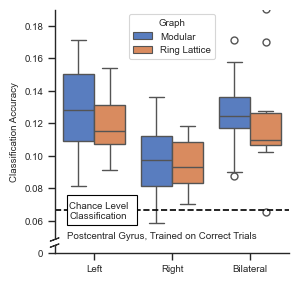

In [28]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)
g = sns.catplot(data=(acc_df
                      .loc[lambda x: (x.roi == 'postcentral-lh') | (x.roi == 'postcentral-rh') | (x.roi == 'postcentral-both')]
                      .replace({'Lattice': 'Ring Lattice'})
                      .replace({'postcentral-lh': 'Left',
                                'postcentral-rh': 'Right',
                                'postcentral-both': 'Bilateral'})
                      .rename(columns={'graph': 'Graph'})
                     ),
                x='roi',
                y='Classification Accuracy',
                hue='Graph',
                order=['Left', 'Right', 'Bilateral'],
                height=3,
                legend_out=False,
                palette='muted',
                kind='box')
# Basic Formatting
g.set(xlabel=None)
g.set(title=None)
g.set(ylim=(0.04, 0.19))

# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]  # Get baseline in axis coordinates
chance_box_height = 0.12
chance_box_width = 0.3
chance_text_center = baseline_axis - 0.035  # vertical center of chance text
roi_text_center = baseline_axis - 0.115  # vertical center of roi label
text_xloc = 0.05  # X location of ROI and chance text box, in axis coordinates
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, roi_text_center, 'Postcentral Gyrus, Trained on Correct Trials', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc, baseline_axis - chance_box_height/2], chance_box_width, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc + 0.01, chance_text_center, 'Chance Level\nClassification', zorder=101, transform=transAxes)

# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))

# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([g.axes.flat[0].get_ylim()[0]], yticks[1:-1]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)

# Save
# g.savefig('images/classification_postcentral_rois_boxplot.pdf')

## Stats: Hemispheric classification diferences

Is the difference between left and right hemispheres significant?

Two-sided paired t-test

In [29]:
from scipy.stats import ttest_rel
x1 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-lh')]
                     )['Classification Accuracy'].values
x2 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-rh')]
                     )['Classification Accuracy'].values
print('Postcentral, Left vs. Right Classification Accuracy')
ttest_rel(x1, x2)

Postcentral, Left vs. Right Classification Accuracy


TtestResult(statistic=6.595984609829273, pvalue=2.670572370731573e-07, df=30)

What about between left and bilateral?

In [119]:
from scipy.stats import ttest_rel
x1 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-both')]
                     )['Classification Accuracy'].values
x2 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-lh')]
                     )['Classification Accuracy'].values
print('Postcentral, Bilateral vs. Left Classification Accuracy')
print(ttest_rel(x1, x2))

Postcentral, Bilateral vs. Left Classification Accuracy
TtestResult(statistic=-0.6374418700626101, pvalue=0.5286723974012844, df=30)


## Figure 3b: Postcentral Gyrus classification vs. response time

/Users/arik/.pyenv/versions/miniconda3-latest/envs/jupyter/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


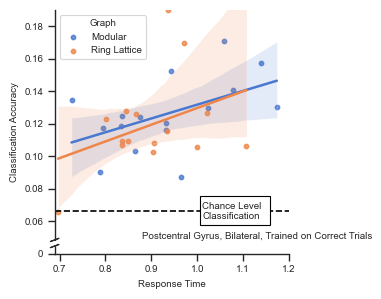

In [36]:
# sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)

g = sns.lmplot(data=(classification_vs_response_time
                     .loc[lambda x: x.session == 'two']
                     .loc[lambda x: x.roi == 'postcentral-both']
                     .replace({'Lattice': 'Ring Lattice'})
                     .rename(columns={'graph': 'Graph'})
                    ),
               x='response_time',
               y='classification_accuracy',
               hue='Graph',
               height=3, # Gives width of 3in
               scatter_kws={"s": 10},
               legend_out=False,
               palette='muted',
               fit_reg=True)
# Basic Formatting
g.set(xlabel='Response Time')
g.set(ylabel='Classification Accuracy')
g.set(title=None)
g.set(xlim=(0.69, 1.2))
g.set(ylim=(0.04, 0.19))
plt.legend(loc='upper left', title='Graph')

# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]  # Get baseline in axis coordinates
baseline = 1/15.0
chance_box_height = 0.12
chance_box_width = 0.3
chance_text_center = baseline_axis - 0.035  # vertical center of chance text
roi_text_center = baseline_axis - 0.115  # vertical center of roi label
text_xloc = 0.62  # X location of ROI and chance text box, in axis coordinates
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc - 0.25, roi_text_center, 'Postcentral Gyrus, Bilateral, Trained on Correct Trials', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc, baseline_axis - chance_box_height/2], chance_box_width, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc + 0.01, chance_text_center, 'Chance Level\nClassification', zorder=101, transform=transAxes)

# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))

# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([g.axes.flat[0].get_ylim()[0]], yticks[1:-1]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save
# g.savefig('images/classification_vs_response_time_session_two_postcentral_combined.pdf')

## Stats: Postcentral gyrus classification accuracy vs. response time

In [37]:
classification_vs_response_time['zscore_response_time'] = ((classification_vs_response_time['response_time'] -
                                                            classification_vs_response_time['response_time'].mean()) /
                                                           classification_vs_response_time['response_time'].std())

roi = 'postcentral-both'
mod = smf.ols(formula='classification_accuracy ~ zscore_response_time * graph',
              data=(classification_vs_response_time
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.188
Model:                                 OLS   Adj. R-squared:                  0.097
Method:                      Least Squares   F-statistic:                     2.077
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):              0.127
Time:                             10:29:52   Log-Likelihood:                 73.349
No. Observations:                       31   AIC:                            -138.7
Df Residuals:                           27   BIC:                            -133.0
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Stats: Postcentral gyrus classification accuracy vs. response accuracy

In [38]:
roi = 'postcentral-both'
mod = smf.ols(formula='classification_accuracy ~ response_accuracy * graph',
              data=(classification_vs_response_accuracy
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.143
Model:                                 OLS   Adj. R-squared:                  0.048
Method:                      Least Squares   F-statistic:                     1.503
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):              0.236
Time:                             10:30:12   Log-Likelihood:                 72.524
No. Observations:                       31   AIC:                            -137.0
Df Residuals:                           27   BIC:                            -131.3
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

# LOC: Classification and Behavior

In [39]:
loc_classification_min = (acc_df
 .loc[lambda x: (x.roi == 'loc-localized')]
).min()['Classification Accuracy']

loc_classification_max = (acc_df
 .loc[lambda x: (x.roi == 'loc-localized')]
).max()['Classification Accuracy']

print(f'Minimum classification accuracy: {loc_classification_min:0.3f}')
print(f'Maximum classification accuracy: {loc_classification_max:0.3f}')

Minimum classification accuracy: 0.154
Maximum classification accuracy: 0.396


## Figure 4a: LOC boxplots

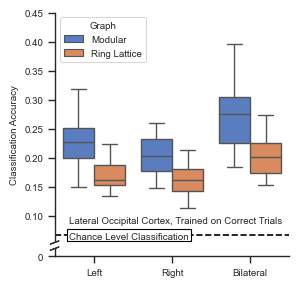

In [40]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)
g = sns.catplot(data=(acc_df
                      .loc[lambda x: (x.roi == 'loc-localized-lh') | (x.roi == 'loc-localized-rh') | (x.roi == 'loc-localized')]
                      .replace({'Lattice': 'Ring Lattice'})
                      .replace({'loc-localized-lh': 'Left',
                                'loc-localized-rh': 'Right',
                                'loc-localized': 'Bilateral'})
                      .rename(columns={'graph': 'Graph'})
                     ),
                x='roi',
                y='Classification Accuracy',
                hue='Graph',
                order=['Left', 'Right', 'Bilateral'],
                height=3,
                legend_out=False,
                palette='muted',
                kind='box')
# Basic Formatting
g.set(xlabel=None)
g.set(ylim=(0.03, 0.45))
g.set(title=None)
# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
chance_box_height = 0.05
text_xloc = 0.06
# Get baseline in axis coordinates
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, baseline_axis + 0.05, 'Lateral Occipital Cortex, Trained on Correct Trials', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc - 0.01, baseline_axis - chance_box_height/2], 0.533, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc, baseline_axis - 0.015, 'Chance Level Classification', zorder=101, transform=transAxes)
# g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
# g.axes.flat[0].text(0.13, baseline - 0.0005, 'Chance Level Classification', zorder=101, ha='center')
# g.axes.flat[0].add_patch(Rectangle([-0.45, baseline-0.005], 1.16, 0.0155, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([0.03], yticks[2:]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save
# g.savefig('images/classification_loc_localized_rois_boxplot.pdf')

## Figure 4b: LOC classification vs. response time

/Users/arik/.pyenv/versions/miniconda3-latest/envs/jupyter/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


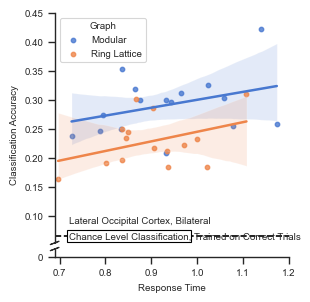

In [41]:
# sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)

g = sns.lmplot(data=(classification_vs_response_time
                     .loc[lambda x: x.session == 'two']
                     .loc[lambda x: x.roi == 'loc-localized']
                     .rename(columns={'graph': 'Graph'})
                     .replace({'Lattice': 'Ring Lattice'})
                    ),
               x='response_time',
               y='classification_accuracy',
               hue='Graph',
               height=3, # Gives width of 3in
               scatter_kws={"s": 10},
               legend_out=False,
               palette='muted',
               fit_reg=True)
# Basic Formatting
g.set(xlim=(0.69, 1.2))
g.set(xlabel='Response Time')
g.set(ylabel='Classification Accuracy')
g.set(title=None)
g.set(ylim=(0.03, 0.45))
# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
chance_box_height = 0.05
text_xloc = 0.06
# Get baseline in axis coordinates
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, baseline_axis + 0.05, 'Lateral Occipital Cortex, Bilateral', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc - 0.01, baseline_axis - chance_box_height/2], 0.533, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc, baseline_axis - 0.015, 'Chance Level Classification, Trained on Correct Trials', zorder=101, transform=transAxes)
# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([0.03], yticks[2:]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save
# g.savefig('images/classification_vs_response_time_session_two_loc_both.pdf')

## Stats: LOC classification accuracy vs. response time

In [42]:
classification_vs_response_time['zscore_response_time'] = ((classification_vs_response_time['response_time'] -
                                                            classification_vs_response_time['response_time'].mean()) /
                                                           classification_vs_response_time['response_time'].std())

roi = 'loc-localized'
mod = smf.ols(formula='classification_accuracy ~ zscore_response_time * graph',
              data=(classification_vs_response_time
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.402
Model:                                 OLS   Adj. R-squared:                  0.335
Method:                      Least Squares   F-statistic:                     6.043
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):            0.00276
Time:                             10:30:27   Log-Likelihood:                 53.354
No. Observations:                       31   AIC:                            -98.71
Df Residuals:                           27   BIC:                            -92.97
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Stats: LOC classification accuracy vs. response accuracy

In [43]:
roi = 'loc-localized'
mod = smf.ols(formula='classification_accuracy ~ response_accuracy * graph',
              data=(classification_vs_response_accuracy
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.316
Model:                                 OLS   Adj. R-squared:                  0.240
Method:                      Least Squares   F-statistic:                     4.162
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):             0.0151
Time:                             10:30:32   Log-Likelihood:                 51.284
No. Observations:                       31   AIC:                            -94.57
Df Residuals:                           27   BIC:                            -88.83
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

## ANOVA: Classification Accuracy differs between graphs

Do we observe higher classification accuracy in participants trained on the modular graph than in participants trained on the lattice graph?

We're looking at both ROI and Graph as factors

Note this section is being run in R. It may be easier to separately export the CSV and then run the analysis in RStudio, etc, but here I'm using rpy2 to directly interface between R and python

In [44]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

robjects.r("""
get_confint <- function(model) {
  return(get_confint_summary(summary(model)))
}

get_confint_summary <- function(summary) {
  coefficients <- summary$coefficients
  
  lb <- coefficients[,c("Estimate")] - 1.96*coefficients[,c("Std. Error")]
  ub <- coefficients[,c("Estimate")] + 1.96*coefficients[,c("Std. Error")]
  
  coef.start <- coefficients[,1:2]
  coef.end <- coefficients[,3:dim(coefficients)[[2]]]
  
  coef.start <- cbind(coef.start, lb)
  colnames(coef.start)[[length(colnames(coef.start))]] <- "95% Conf. Int."
  
  coef.start <- cbind(coef.start, ub) 
  colnames(coef.start)[[length(colnames(coef.start))]] <- ""
  
  coef.start <- cbind(coef.start, coef.end)
  
  
  coef.start <- as_tibble(coef.start, rownames="Variable")
  
  coef.start <-
    coef.start %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.1, ".", "")) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.05, "*", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.01, "**", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.001, "***", Sig.))
  
  colnames(coef.start)[[1]] <- " "
  colnames(coef.start)[[5]] <- " "
  
  return(coef.start)
}
""")

df = classification_vs_response_time.loc[lambda x: (x.roi.isin(['postcentral-rh', 'postcentral-lh', 'postcentral-both'])) & (x.session == 'two')]
df.to_csv('data/classification_vs_response_time_postcentral.csv', index=False)
df = classification_vs_response_time.loc[lambda x: (x.roi.isin(['loc-localized-rh', 'loc-localized-lh', 'loc-localized'])) & (x.session == 'two')]
df.to_csv('data/classification_vs_response_time_loc-localized.csv', index=False)

rstring="""
    cluster_test <- function(){
        library(xtable)
        library(readr)
        library(tibble)
        library(dplyr)
        library(rstatix)
        data <- read_csv('data/classification_vs_response_time_postcentral.csv', col_types='fffdfddd')
        # Two-way mixed ANOVA test
        res.aov <- anova_test(
          data = data, dv = classification_accuracy, wid = subject,
          between = graph, within = roi
          )
        print('Postcentral')
        print(get_anova_table(res.aov))
        data <- read_csv('data/classification_vs_response_time_loc-localized.csv', col_types='fffdfddd')
        # Two-way mixed ANOVA test
        res.aov  <- anova_test(
          data = data, dv = classification_accuracy, wid = subject,
          between = graph, within = roi
          )
        print('LOC')
        print(get_anova_table(res.aov))
    }
"""
rfunc=robjects.r(rstring)

# rdata=ts(traindf.Price.values,frequency=4)
r_df=rfunc()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘rstatix’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




[1] "Postcentral"
ANOVA Table (type III tests)

     Effect DFn DFd      F        p p<.05   ges
1     graph   1  29  0.933 3.42e-01       0.023
2       roi   2  58 34.502 1.34e-10     * 0.248
3 graph:roi   2  58  0.679 5.11e-01       0.006
[1] "LOC"
ANOVA Table (type III tests)

     Effect DFn DFd      F        p p<.05   ges
1     graph   1  29 18.488 1.76e-04     * 0.318
2       roi   2  58 77.532 4.10e-17     * 0.417
3 graph:roi   2  58  1.564 2.18e-01       0.014
